In [ ]:
#Part1: Lyssa Hanson

In [1]:
# Do not change this cell
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed = 1

# Create dataset
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

# Convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)


In [2]:
# TODO: you will design your model here
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # TODO: implement this method
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, 60)
        self.fc4 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.tan = nn.Tanh()
        
    def forward(self, x):
        # TODO: implement this method
        # hidden = self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))
        hidden = self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))
        hidden = self.fc4(self.relu(hidden))
        return hidden.squeeze()
        # return self.sig(hidden.squeeze())

In [3]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    # TODO: implement one epoch of training
    #train it on the correct device:
    X_train, y_train = X_train.to(device), y_train.to(device)
    
    #forward pass
    model.train()
    y_logit = model(X_train)
    y_predict = torch.argmax(y_logit, dim=1)

    #compute loss:
    train_loss = loss_fn(y_logit, y_train)
   
    #compute accuracy:
    correct = torch.eq(y_predict, y_train).sum().item()
    train_acc = (correct / len(y_train)) * 100
    
    #backward pass
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    return train_loss.item(), train_acc


In [4]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    # TODO: implement evaluation on test set
    model.eval()
    #send the device
    X_test, y_test = X_test.to(device), y_test.to(device)
    with torch.inference_mode():
        #get prediction
        y_logit_test = model(X_test)
        y_predict_test = torch.argmax(y_logit_test, dim=1)

        #get loss
        test_loss = loss_fn(y_logit_test, y_test)

        #get acc
        correct = torch.eq(y_predict_test, y_test).sum().item()
        test_acc = (correct / len(y_test)) * 100
    
        return test_loss.item(), test_acc

In [5]:
def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    # Make device
    device = "gpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps" 
    
    torch.manual_seed(random_seed) # do not change this
    # TODO: write codes to train your model here

    #create instance of model:
    model = SimpleModel(2, 4).to(device)
    
    #define the loss and optimizer we will use, I experimented a lot here:
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.002)
    n_epoch = 200

    #initialize empty arrays (this is faster than appending)
    train_losses = np.empty(n_epoch)
    train_accuracies = np.empty(n_epoch)
    test_losses = np.empty(n_epoch)
    test_accuracies = np.empty(n_epoch)
    
    for n in range(n_epoch):
        #train:
        train_loss, train_accuracy = train_step(model, X_train, y_train, loss_fn, optimizer, device)
        #test:
        test_loss, test_accuracy = evaluation_step(model, X_test, y_test, loss_fn, device)

        train_losses[n] = train_loss
        train_accuracies[n] = train_accuracy
        test_losses[n] = test_loss
        test_accuracies[n] = test_accuracy
        
    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [6]:
import pandas as pd
import seaborn as sns

In [7]:
# TODO: plot accuracy curves
def plot_accuracy_performance(train_accuracies, test_accuracies):
    d = {'train accuracy': train_accuracies, 'test accuracy': test_accuracies}
    accuracies = pd.DataFrame(data=d)
    sns.lineplot(data=accuracies)
    plt.title(f"Overall Accuracy Curve \n Maximum Test Accuracy:: {max(accuracies['test accuracy'])}% at epoch: {accuracies[['test accuracy']].idxmax().item()}")
    plt.xlabel("Epoch #")
    plt.ylabel("% Correctly Classified")

In [8]:
# TODO: plot loss curves
def plot_loss_performance(train_losses, test_losses):
    d = {'train loss': train_losses, 'test loss': test_losses}
    losses = pd.DataFrame(data=d)
    sns.lineplot(data=losses)
    plt.title(f"Cross Entropy Loss Curve \n Minimum Test Loss: {min(losses['test loss'])} at epoch: {losses[['test loss']].idxmin().item()}")
    plt.xlabel("Epoch#")
    plt.ylabel("Cross Entropy Loss")
    return

In [9]:
# TODO: plot decision boundary
def plot_decision_boundary(model, X_train, y_train):
    device = "gpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps" 
    
    col1 = 'X1'
    col2 = 'X2'
    min_ex1 = X_train[:, 0].min()
    max_ex1 = X_train[:, 0].max() + .5
    
    min_ex2 = X_train[:, 1].min()
    max_ex2 = X_train[:, 1].max() + .5
    
    arange_step = 0.05
    #create a grid
    xx, yy = np.meshgrid(np.arange(min_ex1, max_ex1, arange_step),
                         np.arange(min_ex2, max_ex2, arange_step))
    grid_data = np.c_[xx.ravel(), yy.ravel()]
    grid_data = torch.from_numpy(grid_data).type(torch.float).to(device)
    model.eval()
    with torch.inference_mode():
        y_logit = model(grid_data).to(device)
        y_predict = torch.argmax(y_logit, dim=1).cpu().numpy()
    
    preds = y_predict.reshape(xx.shape)
    sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train, alpha =0.5, palette='dark')
    plt.title('Decision Boundry')
    plt.contourf(xx, yy, preds, alpha = .23)
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='upper right')
    plt.show()

In [10]:
# Do not change this cell
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

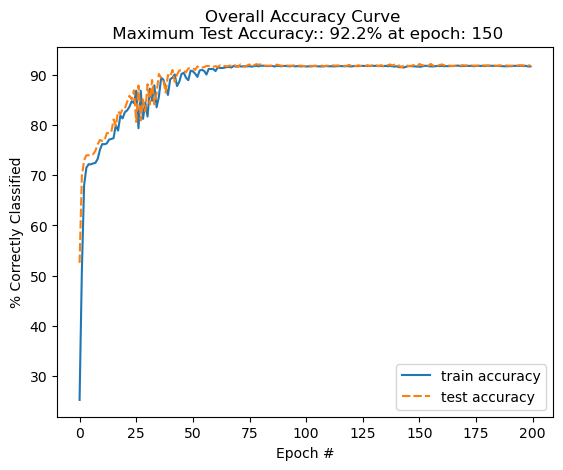

In [11]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, test_accuracies)

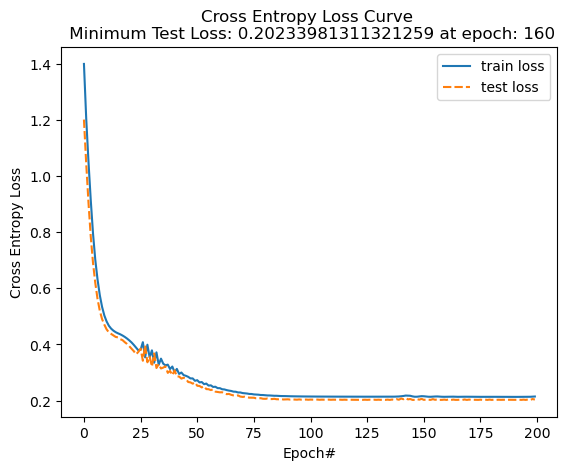

In [12]:
# Do not change this cell
plot_loss_performance(train_losses, test_losses)

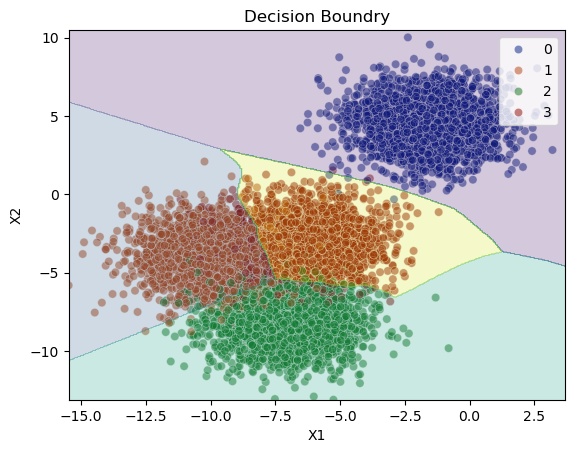

In [13]:
# Do not change this cell
plot_decision_boundary(model, X_train, y_train)

In [14]:
#Citations: In addition to her example and the class slides
# ADAM OPtimizer -> https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

# plt.contourf() -> https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07

# tensor to numpy array: https://saturncloud.io/blog/convert-a-tensor-to-a-numpy-array-in-tensorflow/#:~:text=The%20simplest%20way%20to%20convert,and%20elements%20as%20the%20tensor.
